<a href="https://colab.research.google.com/github/itzem-vg/Practicos-SIS420-COM200/blob/main/LAB6/v1_blackjack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 11.1 MB/s eta 0:00:00


In [10]:
!pip install gym==0.26.0

import gym
from gym.wrappers import RecordEpisodeStatistics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 710.3/710.3 kB 9.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.0-py3-none-any.whl size=826271 sha256=b5103bcfe883fe44814064c9ddd0ca0b10f096df2050d8a9158ea0d3b1fd1d94
  Stored in directory: /root/.cache/pip/wheels/cd/da/7c/a034980e59e34687bfb6cfa3a5f3e9b389264a0c59519c59fa
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.9 requires gym<=0.25.2, but you have gym 0.26.0 which is incompatible.



# Solving Blackjack with Q-Learning


<img src="file://_static/img/tutorials/blackjack_AE_loop.jpg" width="650" alt="agent-environment-diagram" class="only-light">
<img src="file://_static/img/tutorials/blackjack_AE_loop_dark.png" width="650" alt="agent-environment-diagram" class="only-dark">

IMAGE
[texto del enlace](https://https://gymnasium.farama.org/_images/blackjack.gif)

En este tutorial, exploraremos y resolveremos el *Blackjack-v1*
ambiente.

**Blackjack** es uno de los juegos de cartas de casino más populares que también es infame por ser vencible bajo ciertas condiciones. Esta versión de
el juego usa una baraja infinita (robamos las cartas con reemplazo), por lo que
Contar cartas no será una estrategia viable en nuestro juego simulado.
La documentación completa se puede encontrar en https://gymnasium.farama.org/environments/toy_text/blackjack

**Objective**: Para ganar, el monto de tu tarjeta debe ser mayor que el
distribuidores sin exceder los 21.

**Actions**: Los agentes pueden elegir entre dos acciones:
 - plantarse (0): el jugador no toma más cartas
 - hit (1): el jugador recibirá otra carta, sin embargo, el jugador podría superar los 21 y pasarse.

**Approach**: Para resolver este entorno usted mismo, puede elegir su
Algoritmo RL discreto favorito. La solución presentada utiliza *Q-learning*
(un algoritmo RL sin modelo).




## Imports and Environment Setup




In [11]:
# Author: Till Zemann
# License: MIT License

from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym

# Comencemos creando el entorno del blackjack.
# Nota: Vamos a seguir las reglas de Sutton & Barto.
# Puedes encontrar otras versiones del juego a continuación para que experimentes.

env = gym.make("Blackjack-v1", sab=True)


## Otras configuraciones de entorno posibles son:
```
env = gimnasio.make('Blackjack-v1', natural=Verdadero, sab=Falso)
```




  ## Si se debe dar una recompensa adicional por comenzar con un blackjack natural, es decir, comenzar con un as y un diez (la suma es 21).


```
 env = gimnasio.make('Blackjack-v1', natural=False, sab=False)
```


  ### Si se deben seguir las reglas exactas descritas en el libro de Sutton y Barto. Si "sab" es "Verdadero", se ignorará el argumento de la palabra clave "natural".



## Observando el medio ambiente

En primer lugar, llamamos a ``env.reset()`` para iniciar un episodio. Esta función
Restablece el entorno a una posición inicial y devuelve un valor inicial.
``observación``. Generalmente también configuramos ``hecho = False``. Esta variable
Será útil más adelante para comprobar si un juego finaliza (es decir, si el jugador gana o pierde).




In [12]:
# restablecer el entorno para obtener la primera observación
done = False
observation, info = env.reset()

# observación = (16, 9, Falso)

NOTA - Tenga en cuenta que nuestra observación es una tupla de 3 que consta de 3 valores:

- La suma actual de los jugadores.
- Valor de la carta boca arriba del crupier
- Booleano si el jugador tiene un as utilizable (un as es utilizable si
   cuenta como 11 sin reventar)




## Ejecutando una acción

Después de recibir nuestra primera observación, sólo vamos a utilizar el
Función ``env.step(action)`` para interactuar con el entorno. Este
La función toma una acción como entrada y la ejecuta en el entorno.
Debido a que esa acción cambia el estado del medio ambiente, regresa
cuatro variables útiles para nosotros. Estos son:

- ``next_state``: Esta es la observación que recibirá el agente
   después de realizar la acción.
- ``recompensa``: Esta es la recompensa que recibirá el agente después
   tomando la acción.
- ``terminado``: Esta es una variable booleana que indica si o
   No el medio ambiente ha terminado.
- ``truncado``: Esta es una variable booleana que también indica si
   el episodio terminó por truncamiento anticipado, es decir, se alcanza un límite de tiempo.
- ``info``: Este es un diccionario que puede contener información adicional.
   información sobre el medio ambiente.

Las variables ``next_state``, ``reward``, ``terminate`` y ``truncated`` son
se explica por sí mismo, pero la variable ``info`` requiere algo de información adicional.
explicación. Esta variable contiene un diccionario que podría tener algunas
información adicional sobre el entorno, pero en Blackjack-v1
entorno, puedes ignorarlo. Por ejemplo, en entornos Atari, el
El diccionario de información tiene una clave ``ale.lives`` que nos dice cuántas vidas tiene
El agente se ha ido. Si el agente tiene 0 vidas, entonces el episodio termina.

Tenga en cuenta que no es una buena idea llamar a ``env.render()`` en su entrenamiento.
bucle porque el renderizado ralentiza mucho el entrenamiento. Más bien intenta construir
un bucle adicional para evaluar y mostrar al agente después del entrenamiento.




In [13]:
# sample a random action from all valid actions
action = env.action_space.sample()
# action=1

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)

# observation=(24, 10, False)
# reward=-1.0
# terminated=True
# truncated=False
# info={}

Una vez ``terminado = True`` o ``truncado=True``, debemos detener el
episodio actual y comenzar uno nuevo con ``env.reset()``. Si usted
continuar ejecutando acciones sin restablecer el entorno, todavía
responde pero el resultado no será útil para el entrenamiento (incluso podría ser
perjudicial si el agente se entera de datos no válidos).




## Construyendo un agente

¡Construyamos un ``agente Q-learning`` para resolver *Blackjack-v1*! necesitaremos
algunas funciones para elegir una acción y actualizar la acción de los agentes
valores. Para garantizar que los agentes exploren el entorno, una posible
La solución es la estrategia "épsilon-codiciosa", donde elegimos un
acción con el porcentaje ``epsilon`` y la acción codiciosa (actualmente
valorado como el mejor) ``1 - épsilon``.




In [14]:
class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Inicializar un agente de aprendizaje por refuerzo con un diccionario vacío
        de valores de estado-acción (q_values), una tasa de aprendizaje y un épsilon.

        Argumentos:
            learning_rate: la tasa de aprendizaje
            inicial_epsilon: el valor épsilon inicial
            epsilon_decay: La decadencia de épsilon
            final_epsilon: el valor épsilon final
            discount_factor: el factor de descuento para calcular el valor Q
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

Para entrenar al agente, le dejaremos reproducir un episodio (uno completo).
juego se llama episodio) a la vez y luego actualizar sus valores Q después
cada episodio. El agente tendrá que vivir muchos episodios para
Explorar suficientemente el entorno.

Ahora deberíamos estar preparados para construir el circuito de formación.




In [15]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

ENTRENAMIENTO

Información: Los hiperparámetros actuales están configurados para capacitar rápidamente a un agente decente.
Si desea converger hacia la política óptima, intente aumentar
los n_episodios en 10x y reducir la tasa de aprendizaje (por ejemplo, a 0,001).




In [18]:
env = gym.make("Blackjack-v1") # o tu entorno deseado
env = RecordEpisodeStatistics(env) #se eliminó deque_size = n_episodes


In [17]:
#env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 100000/100000 [00:26<00:00, 3749.78it/s]


In [21]:
#env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes) SIIIIIIIIIII
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # Juega un episodio
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # Actualiza el agente
        agent.update(obs, action, reward, terminated, next_obs)

        # Actualiza si el entorno ha terminado y la observación actual
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 100000/100000 [00:26<00:00, 3838.19it/s]


## Visualizacion de entrenamiento





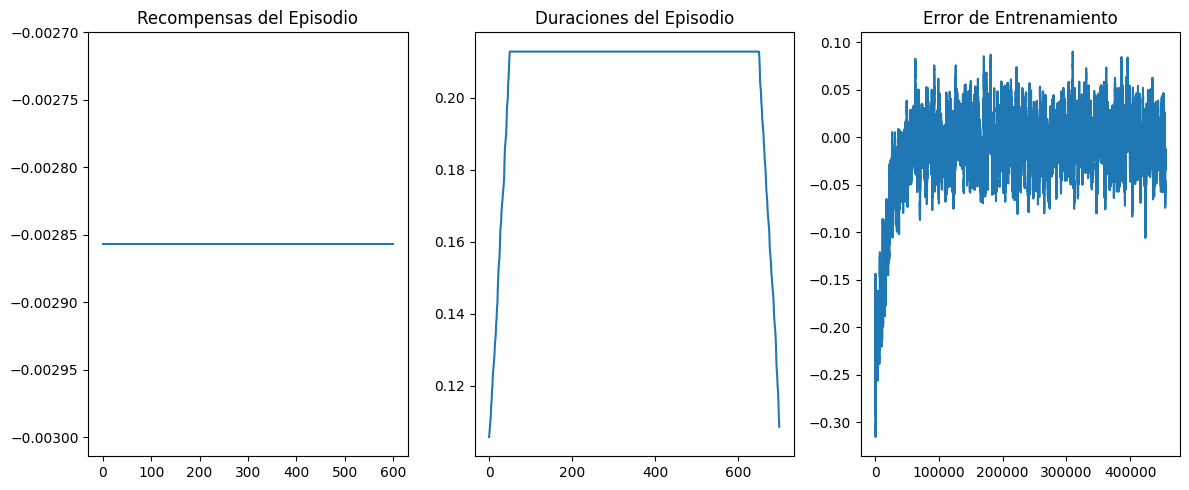

In [27]:
#  después de ejecutar los episodios
rolling_length = 700
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Recompensas del Episodio")
# Calcula y asigna un promedio móvil de los datos para proporcionar un gráfico más suave
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Duraciones del Episodio")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Error de Entrenamiento")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

ValueError: v cannot be empty

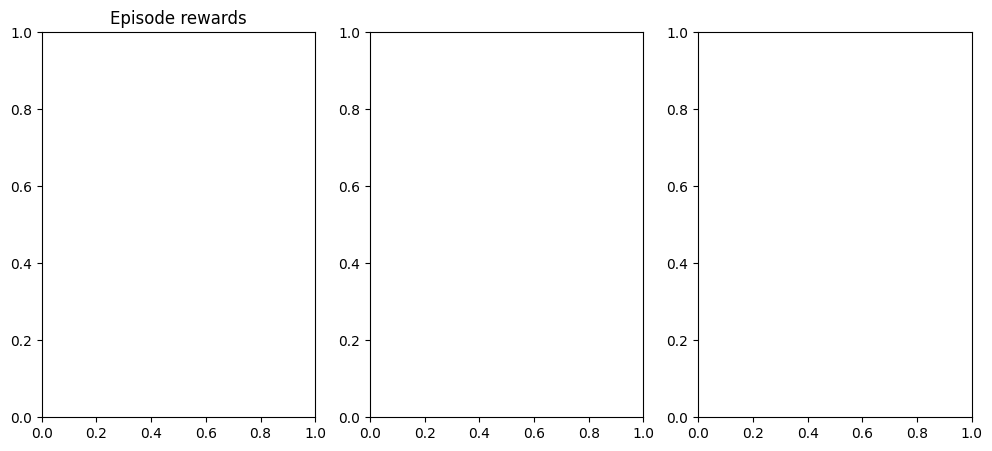

In [19]:
"""rolling_length = 500 #SALE ERROR
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()"""

<img src="file://_static/img/tutorials/blackjack_training_plots.png">




## Visualising the policy



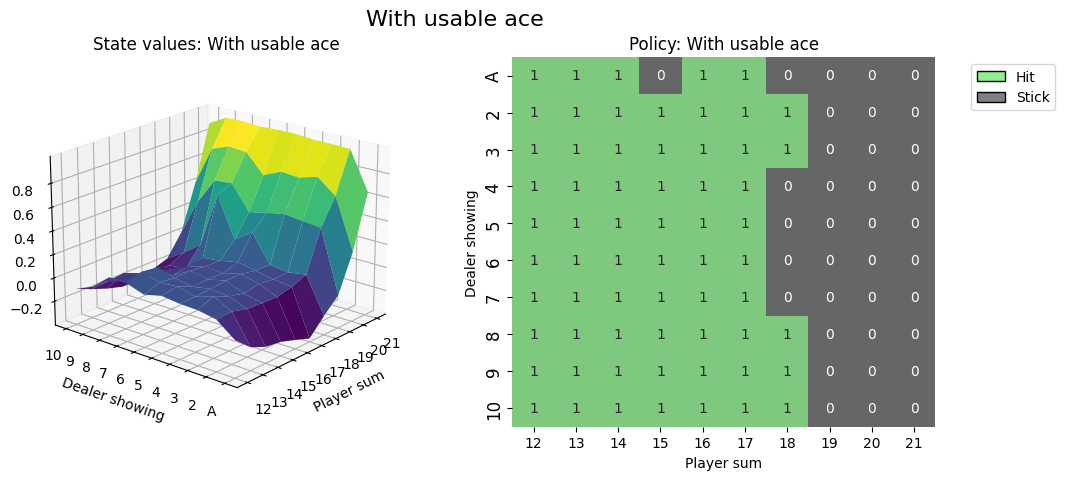

In [23]:
def create_grids(agent, usable_ace=False):
    """Crear valor y cuadrícula de políticas con un agente."""
    # convertir nuestros valores de acción de estado en valores de estado
    # y crear un diccionario de políticas que relacione las observaciones con las acciones
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"), #Golpear
        Patch(facecolor="grey", edgecolor="black", label="Stick"), #Palo
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

<img src="file://_static/img/tutorials/blackjack_with_usable_ace.png">




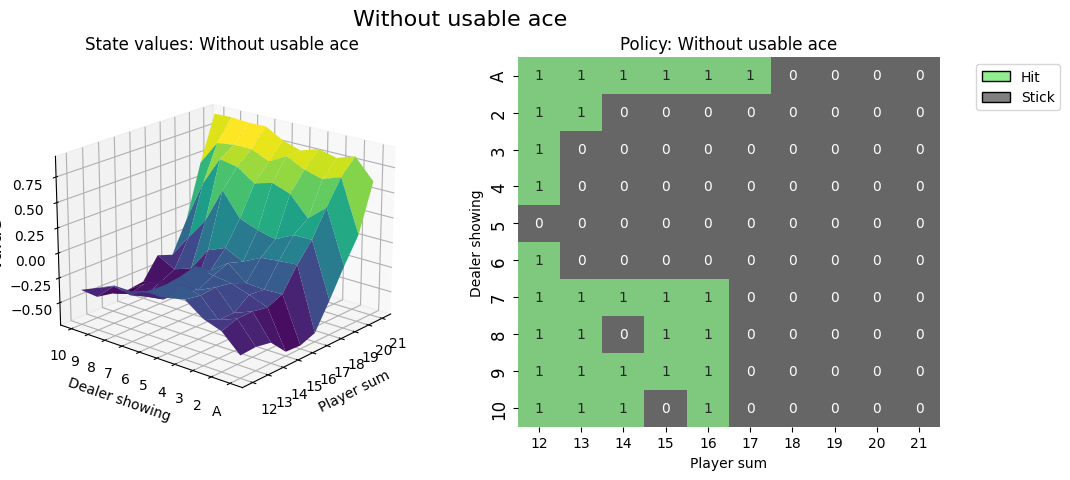

In [ ]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()